In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils import *
from KDEpy import FFTKDE #https://github.com/tommyod/KDEpy

### Building response maps

1. Load a python dictionary with stimulus direction as key, and a list of spike trains (one per trial) as value. Each spike train is itself a list of spike times (ms).

In [2]:
with open('example_train_dicts.pkl','rb') as f:
    train_dicts = pickle.load(f)

In [3]:
#printout example
cell = 21
mystim = 'gratW12.5'
mydir = 0
print(len(train_dicts[cell][mystim][mydir]),'trials:')
train_dicts[cell][mystim][mydir]

9 trials:


[array([  84.15,  106.7 ,  117.9 ,  158.7 ,  185.9 ,  374.05,  385.2 ,
         399.05,  408.35,  420.55,  433.4 ,  458.4 ,  644.85,  656.1 ,
         681.95,  706.  ,  911.75,  952.25,  971.65, 1156.3 , 1187.  ,
        1216.  , 1231.5 ]),
 array([ 114.08,  119.78,  128.43,  151.73,  197.53,  385.68,  401.28,
         419.88,  442.33,  459.73,  652.88,  683.93,  694.33,  913.93,
         928.18,  944.38,  965.88,  973.13, 1187.78]),
 array([  86.93,  101.53,  116.63,  128.73,  146.53,  171.53,  191.13,
         383.23,  397.33,  409.83,  419.48,  437.63,  462.68,  652.38,
         666.08,  686.58,  707.68,  918.33,  930.73,  960.63,  988.03,
        1179.83, 1207.38]),
 array([  99.62,  111.37,  129.42,  137.92,  151.92,  162.27,  173.87,
         371.92,  388.27,  409.62,  419.22,  433.82,  647.02,  661.67,
         680.67,  704.77,  900.12,  914.42,  924.67,  945.22,  957.92,
        1192.72]),
 array([ 119.8 ,  136.1 ,  149.35,  162.3 ,  374.85,  390.55,  412.4 ,
         424.6 ,  

In [4]:
#choose cell id and stimulus
mycell_id = 21
mystim = 'gratW12.5'

#load full train dict (all dirs) for this cell and stim
train_dict = train_dicts[mycell_id][mystim]

2. Displaying trial spike rasters and resulting trial-averaged, kernel-smoothed responses.

In [5]:
from KDEpy import FFTKDE
def getResponseCurve(train_dict, total_trial_len, bw=None, samp_interval=1, MINBW=10, MAXBW=50):

    """Computes smooth trial-averaged response to a stim in all directions from spike trains
    using a kernel density estimator."""
    
    ts = np.arange(0,total_trial_len+samp_interval,samp_interval)
    x_ts = .5*(ts[:-1]+ts[1:]) #sample at the midpoints between sampling intervals

    all_ISJs = []
    
    
    fftkde = None
    if bw is None:
        # if no pre-specified kernel bandwidth, 
        #  auto-estimate within range [MINBW, MAXBW]
        bw, fftkde = fitSmoothingKernelBandwidth(train_dict, total_trial_len)
        if bw is not None:
            bw = max(min(MAXBW,bw),MINBW)
            fftkde.bw = bw
        else:
            bw = MAXBW

    for di,d in enumerate(sorted(train_dict)):

        full_train = []
        for triali,train in enumerate(train_dict[d]):
            if train.size == 0: continue
            assert max(train) < total_trial_len
            full_train += list(train)    

        data = np.array(full_train)
        data.sort()
        n = data.size
        if fftkde is None:
            fftkde = FFTKDE(kernel='gaussian', bw=bw) #initialize kernel density estimator

        try:
            fftkde = fftkde.fit(data)
            #extend sampling one unit before and after trial
            ext_x_ts = np.r_[x_ts[0]-samp_interval,x_ts,x_ts[-1]+samp_interval]
            #then crop after applying the kernel
            y = fftkde.evaluate(ext_x_ts)[1:-1]

        except:
            #error occurs in the rare cases when there are zero spikes. print out to double-check
            print(f'fftkde failed: {n} data points')
            y = np.zeros_like(x_ts)


        all_ISJs.append(y*n*1000/len(train_dict[d])) #convert density to spks/sec
    return np.array(all_ISJs), x_ts

trial_len = 1250 #ms
bw = 50 #kernel bandwidth -- can be auto-selected using None
samp_interval = 1 #ms
all_ISJs, sample_ts = getResponseCurve(train_dict, trial_len, bw, samp_interval)

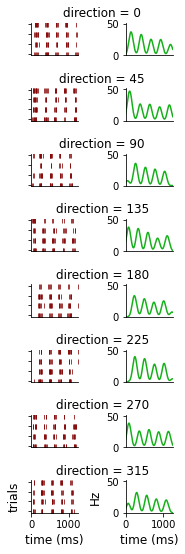

In [6]:
dirs = sorted(train_dict) #directions: 0, 45, 90, 135, 180, 225, 270, 315
prestimlen = 0

maxNrasters_to_show = 4
axlblsz = 12


f,axes = subps(len(dirs),2,.65*1.5,.65*2)

for di,d in enumerate(dirs):
    ax = axes[di,0]

    for triali,train in enumerate(train_dict[d]):
        if train.size == 0: continue
            
        if triali < maxNrasters_to_show:
            ax.scatter(train+prestimlen,[triali]*len(train),s=25,alpha=1,c='maroon', marker='|',lw=.75)
        
    ax.set_yticks(range(maxNrasters_to_show))
    ax.set_yticklabels([])
    if di == len(dirs) -1:
        ax.set_xticks(np.arange(0,trial_len,1000))
        ax.tick_params(labelsize=10)
        
        ax.set_ylabel('trials',size=axlblsz)
        ax.set_xlabel('time (ms)',size=axlblsz)
    else:
        ax.set_xticks([])

    ax.set_xlim(-prestimlen,trial_len)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

maxFR = all_ISJs.max()

for di,d in enumerate(dirs):

    ax = axes[di,1]
    ax.plot(sample_ts, all_ISJs[di],c='xkcd:green')
    ax.set_ylim(0,maxFR*1.1)
    
    ax.set_title(f'direction = {d}', size=axlblsz, x=-.5)
    ax.tick_params(labelsize=10)
    if di == len(dirs) - 1:
        ax.set(xticks=np.arange(prestimlen,trial_len+prestimlen,1000), xticklabels=np.arange(prestimlen,trial_len+prestimlen,1000)-prestimlen)
        ax.set_ylabel('Hz',size=axlblsz)
        ax.set_xlabel('time (ms)',size=axlblsz)
        

    else:
        ax.set_xticks([])
#         ax.set_yticks([])

    ax.set_xlim(-prestimlen,trial_len)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

        
f.tight_layout()
plt.show()

3. Display responses to all directions as a two-dimensional "response map"

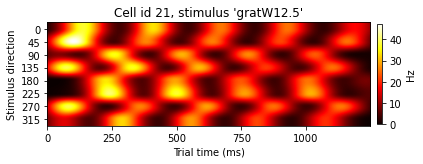

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
cb = ax.imshow(all_ISJs,cmap='hot',aspect=50, )
ax.set_ylabel('Stimulus direction')
ax.set(yticks=range(all_ISJs.shape[0]), yticklabels=sorted(train_dict))
ax.set_xlabel('Trial time (ms)')
ax.set(xticks=range(0,all_ISJs.shape[1],250//samp_interval), xticklabels=np.arange(0,trial_len,250))
ax.set_title(f"Cell id {mycell_id}, stimulus '{mystim}'")
fig.colorbar(cb,ax=ax,fraction=0.015, pad=0.02, label='Hz')
plt.show()

4. Repeat for all six stimulus classes and display full response profile

In [8]:
def plotFullResponseProfile(all_maps, nrows, aspect, rowsz, colsz, stimnames=None):
    """Displays a list of response maps organized as a grid of subplots"""
    
    ncols = int(np.ceil(len(all_maps)/nrows))
    
    f,axes = plt.subplots(nrows,ncols,figsize=(ncols*colsz,nrows*rowsz))
    if nrows*ncols == 1:
        axes = np.array([axes])

    vmax = np.array(all_maps).max()
    for i in range(len(all_maps)):
        ax = axes.ravel()[i]
        response = all_maps[i]
        cb = ax.imshow(response,cmap='hot',vmin=0,vmax=vmax,aspect=aspect)
        
        if stimnames is not None:
            ax.set_title(stimnames[i])
        
        ax.set_xticks([])
        ax.set(yticks=[])
    f.tight_layout()
    plt.show()

cell id 21


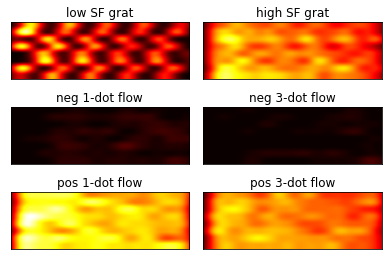

cell id 464


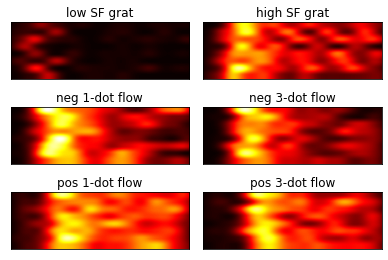

In [9]:
stims_to_use = ['gratW12.5', 'gratW2', '-1dotD2s2bg', '-3dotD2s2bg', '+1dotD2s2bg', '+3dotD2s2bg']
stim_names_to_show = ['low SF grat', 'high SF grat', 'neg 1-dot flow', 'neg 3-dot flow', 'pos 1-dot flow', 'pos 3-dot flow', ]
assert len(stim_names_to_show) == len(stims_to_use)
for cell_id in [21,464]:
    print(f'cell id {cell_id}')

    all_response_maps = []

    #compute overall range of firing rates to plot all responses using a common scale
    for stimname in stims_to_use:
        response_map, _ = getResponseCurve(train_dicts[cell_id][stimname],trial_len,bw)
        all_response_maps.append(response_map)

    #plot responses arragned as a grid
    plotFullResponseProfile(all_response_maps, 3, 50, 1.25, 2.75, stimnames=stim_names_to_show)

### Building the tensor

1. Collect response maps for each cell and stimulus

In [24]:
cell_ids_to_use = [21, 464]

stims_to_use = ['gratW12.5', 'gratW2', '-1dotD2s2bg', '-3dotD2s2bg', '+1dotD2s2bg', '+3dotD2s2bg']

# normalize each response to prevent biasing the decomposition toward sustained responses or cells with higher FRs
normalize_responses = True

# keep a list of statistically significant stims for each cell
# (non-signif. responses will be zeroed-out for now to reduce noise and help tensor decomposition)
significant_stims = {21: [0,1,4,5], 464: range(6)} 


#keep track of which cell ids and stims were actually used in the tensor
cells_stims_used = []
all_zeroed_stims = {}
# also make note of original max FRs for each stim
cell_maxFRs = []


response_len = len(dirs) * trial_len//samp_interval

# build two versions of the tensor:
# one containing statistically significant responses only...
sigT = np.zeros((len(cell_ids_to_use), len(stims_to_use), response_len))
# ...and another containing all original responses
allT = np.zeros((len(cell_ids_to_use), len(stims_to_use), response_len))

#for each cell
for ci,cell_id in enumerate(cell_ids_to_use):
    
    sig_stims_used = []
    zeroed_stims = []
    stim_maxFRs = []
    # for each stim
    for si,sname in enumerate(stims_to_use):
        
        assert significant_stims[cell_id] #every cell used must have at least one signif response
        
        response_map, _ = getResponseCurve(train_dicts[cell_id][sname], trial_len, bw)

        
        # flatten response map before adding to tensor
        res = response_map.ravel(order='F')# use Fortran order (colwise) for later use with matlab
        
        stim_maxFRs.append(res.max())
        
        if normalize_responses:
            norm = np.linalg.norm(res)
            if norm > 0:
                res /= norm
          
        allT[ci,si] = res
        
        if si in significant_stims[cell_id]:
            sigT[ci,si] = res
            sig_stims_used.append(si)
        else:
            zeroed_stims.append(si)
        
    cells_stims_used.append((cell_id, sig_stims_used))
    cell_maxFRs.append(np.array(stim_maxFRs))
    if zeroed_stims:
        all_zeroed_stims[ci] = tuple(zeroed_stims)
            
sigT.shape

(2, 6, 10000)

In [11]:
#signif stims per cell added to sigT
list(zip(cell_ids_to_use, cells_stims_used))

[(21, array([0, 1, 4, 5])), (464, array([0, 1, 2, 3, 4, 5]))]

In [12]:
#statistically significant responses have unit norm:
print(np.linalg.norm(sigT,axis=2))

[[1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


In [14]:
print('Max instantaneous FR per stim')
for cid, maxfrs in zip(cell_ids_to_use, cell_maxFRs):
    print(f'cell_id {cid}', end=': ')
    npprint(maxfrs,1)

Max instantaneous FR per stim
cell_id 21: [47.3 43.2  5.8  4.9 51.3 38.2]
cell_id 464: [16.4 38.1 42.2 40.5 39.2 36.8]
